**1. Lab Setup**







In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**2. Extract Food waste datasets**



In [8]:
import zipfile
import os

local_zip = '/tmp/foodwasteData.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

**3. Train Models**

In [12]:
base_dir = '/content/foodwasteData/DATASET'
train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with training organic pictures
train_organic_dir = os.path.join(train_dir, 'O')

# Directory with training recyclable pictures
train_recycle_dir = os.path.join(train_dir, 'R')

# Directory with validation organic pictures
validation_organic_dir = os.path.join(validation_dir, 'O')

# Directory with validation recyclable pictures
validation_recycle_dir = os.path.join(validation_dir, 'R')

print('total training organic images:', len(os.listdir(train_organic_dir)))
print('total training recycyle images:', len(os.listdir(train_recycle_dir)))
print('total validation organic images:', len(os.listdir(validation_organic_dir)))
print('total validation recycyle images:', len(os.listdir(validation_recycle_dir)))

total training organic images: 4800
total training recycyle images: 2142
total validation organic images: 616
total validation recycyle images: 579


**4. Output Train result**

(168, 299, 3)
(205, 246, 3)
(169, 299, 3)
(157, 321, 3)
(160, 314, 3)
(150, 300, 3)
(187, 269, 3)
(168, 300, 3)


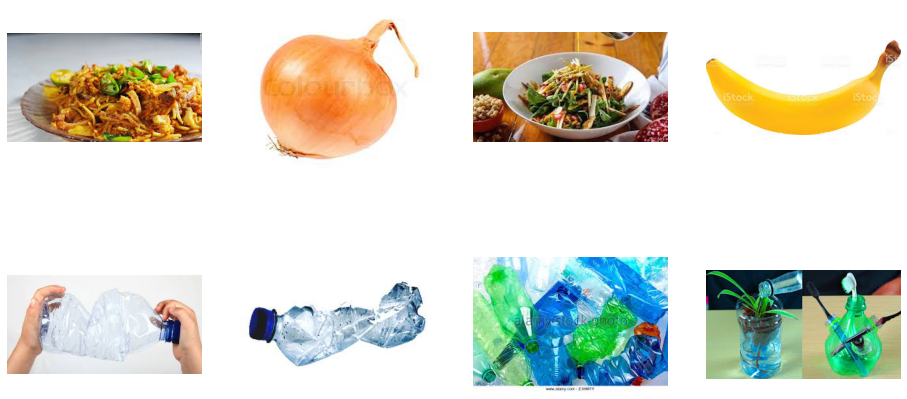

In [17]:
train_organic_fnames = os.listdir(train_organic_dir)
train_recycle_fnames = os.listdir(train_recycle_dir)
train_recycle_fnames.sort()

%matplotlib inline

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 4
next_organic_pix = [os.path.join(train_organic_dir, fname) 
                for fname in train_organic_fnames[pic_index-4:pic_index]]
next_recycle_pix = [os.path.join(train_recycle_dir, fname) 
                for fname in train_recycle_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_organic_pix + next_recycle_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  if img_path.endswith('.DS_Store'):
    os.remove(img_path)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  print(img.shape)

plt.show()

**5. Evaluate gain and loss precision**

In [18]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

**6. Output Class Evaluation results **

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,               # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        shuffle=True,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='binary')

Found 6940 images belonging to 2 classes.
Found 1193 images belonging to 2 classes.


In [20]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

**7. Output Precision Evaluation results **

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

**8. Compile Evaluated models**

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0005),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=8,
      validation_data=validation_generator,
      verbose=2,
      shuffle=True)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


217/217 - 25s - loss: 0.4112 - acc: 0.8336 - val_loss: 0.5060 - val_acc: 0.8609 - 25s/epoch - 113ms/step
Epoch 2/8
217/217 - 11s - loss: 0.3182 - acc: 0.8746 - val_loss: 0.3339 - val_acc: 0.8927 - 11s/epoch - 52ms/step
Epoch 3/8
217/217 - 11s - loss: 0.2790 - acc: 0.8882 - val_loss: 0.4171 - val_acc: 0.8701 - 11s/epoch - 53ms/step
Epoch 4/8
217/217 - 11s - loss: 0.2473 - acc: 0.9014 - val_loss: 0.3512 - val_acc: 0.8961 - 11s/epoch - 53ms/step
Epoch 5/8
217/217 - 11s - loss: 0.2189 - acc: 0.9115 - val_loss: 0.3488 - val_acc: 0.8961 - 11s/epoch - 52ms/step
Epoch 6/8
217/217 - 11s - loss: 0.2028 - acc: 0.9222 - val_loss: 0.2588 - val_acc: 0.9229 - 11s/epoch - 52ms/step
Epoch 7/8
217/217 - 12s - loss: 0.1854 - acc: 0.9314 - val_loss: 0.2301 - val_acc: 0.9195 - 12s/epoch - 56ms/step
Epoch 8/8
217/217 - 11s - loss: 0.1664 - acc: 0.9380 - val_loss: 0.3480 - val_acc: 0.9103 - 11s/epoch - 53ms/step


**9. Visualize compiled data**

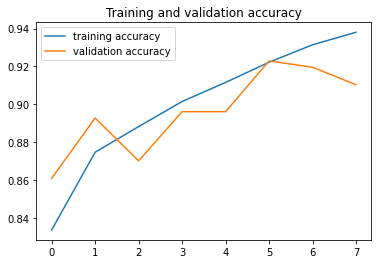

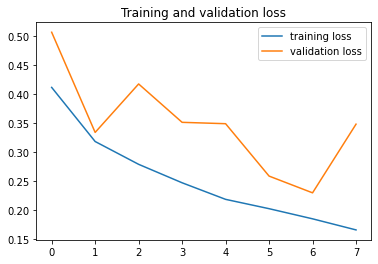

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [24]:
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 1193 images belonging to 2 classes.
{'O': 0, 'R': 1}


**10. Evaluate prediction accurracy**

In [25]:
val_pred_prob = model.predict(val_visual)

In [26]:
# must get index array before getting predictions!
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'

# getting predictions in the form of probablities 
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values 
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
  misclassified_filepaths.append(val_visual.filepaths[dir_index])
  if pred_label != true_label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

Model predictions: [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,

**11. Evaluate and visualize classifier's accuracy**

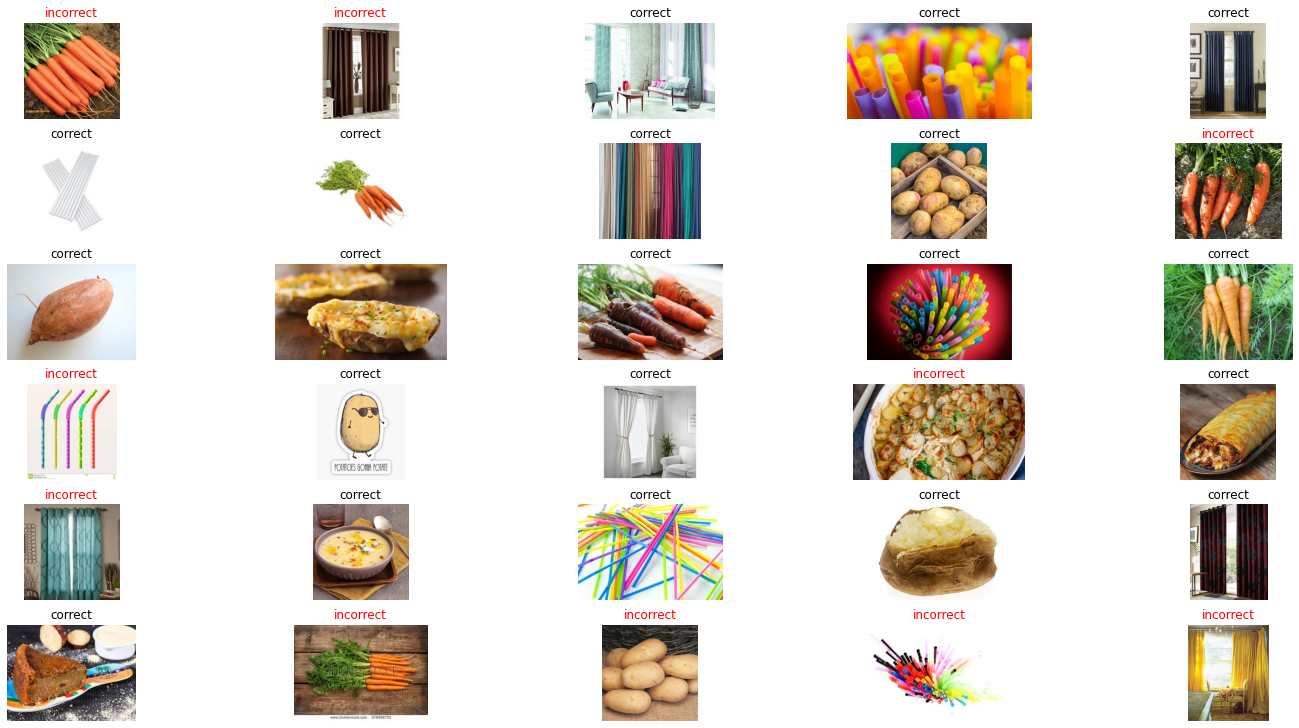

In [27]:
# obtaining the images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plots first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()